In [1]:
import warnings
warnings.filterwarnings('ignore')
import os
os.chdir('/home/data/fhz/project/phmap_package')

import scanpy as sc
import phmap


   ____  _   __  __    _    ____  
  |  _ \| | |  \/  |  / \  |  _ \ 
  | |_) | |_| |\/| | / _ \ | |_) |
  |  __/|  _  |  | |/ ___ \|  __/ 
  |_|   |_| |_|  |_/_/   \_\_|    
                                  
  🔬 Multi-task Learning Framework for Cell Type Classifier
  🫁 pretrained model on pulmonary hypertension scRNA-seq data
    
🔖 Version: 0.1.0

🧬 Detecting CUDA devices…
✅ [GPU 0] NVIDIA GeForce RTX 4090
   • Total memory: 23.6 GB
   • Compute capability: 8.9
   • CUDA version: 12.1



### Load model

In [2]:
model = phmap.load_pretrained_model('full_model')

INFO:phmap.core.classifier:Model loaded from /home/data/fhz/project/phmap_package/phmap/models/full_model/cell_type_classifier_full.pth
INFO:phmap.core.predictor:Model and metadata loaded from /home/data/fhz/project/phmap_package/phmap/models/full_model/cell_type_classifier_full.pth and /home/data/fhz/project/phmap_package/phmap/models/full_model/cell_type_classifier_full_metadata.pkl


#### Test dataset

##### Preprocessing

In [3]:
qurey = sc.read_h5ad("phmap/test_data/GSE228643_PF-PH/PRJNA950922_PF_PH_raw.h5ad")
qurey

AnnData object with n_obs × n_vars = 41493 × 36601
    obs: 'sample', 'dataset', 'group', 'batch'
    var: 'ENSEMBL', 'SYMBOL'

In [5]:
qurey.layers['counts'] = qurey.X.copy()

In [6]:
qurey.var.head()

,ENSEMBL,SYMBOL
ENSG00000243485,ENSG00000243485,MIR1302-2HG
ENSG00000237613,ENSG00000237613,FAM138A
ENSG00000186092,ENSG00000186092,OR4F5
ENSG00000238009,ENSG00000238009,AL627309.1
ENSG00000239945,ENSG00000239945,AL627309.3


In [7]:
# use symbol as gene name
# Remove duplicated genes based on SYMBOL
qurey = qurey[: ,~qurey.var["SYMBOL"].duplicated()]
qurey.var_names = qurey.var["SYMBOL"].copy()
qurey.var.index.name = None
qurey

AnnData object with n_obs × n_vars = 41493 × 36591
    obs: 'sample', 'dataset', 'group', 'batch'
    var: 'ENSEMBL', 'SYMBOL'
    layers: 'counts'

In [8]:
qurey.var.head()

,ENSEMBL,SYMBOL
MIR1302-2HG,ENSG00000243485,MIR1302-2HG
FAM138A,ENSG00000237613,FAM138A
OR4F5,ENSG00000186092,OR4F5
AL627309.1,ENSG00000238009,AL627309.1
AL627309.3,ENSG00000239945,AL627309.3


##### Calculate some qc indicators

In [9]:
# 线粒体基因
qurey.var["mt"] = qurey.var_names.str.startswith("MT-")
# 核糖体基因
qurey.var["ribo"] = qurey.var_names.str.startswith(("RPS", "RPL"))
# 血红蛋白基因
qurey.var["hb"] = qurey.var_names.str.contains(("^HB[^(P)]")) 

sc.pp.calculate_qc_metrics(
    qurey, qc_vars=["mt", "ribo", "hb"], inplace=True, percent_top=[20], log1p=True
)

Text(0.5, 1.0, 'perc_mt distribution')

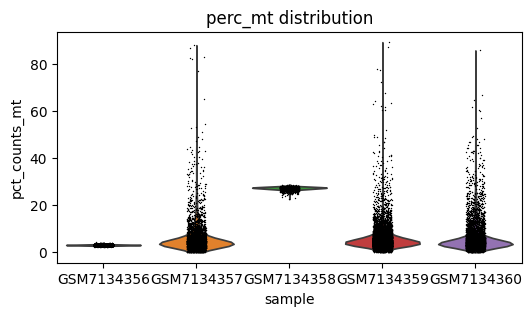

In [10]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(6, 3))
sc.pl.violin(qurey, keys=["pct_counts_mt"], groupby="sample", ax=ax,
             show=False)
plt.title("perc_mt distribution")

##### Quality control

In [11]:
n0 = qurey.shape[0]
print(f'Original cell number: {n0}')

Original cell number: 41493


In [12]:
import numpy as np
tresh={
    # Using a relaxed mitochondrial filtering threshold
    'mito_perc': 30, 'nUMIs': 500, 'detected_genes': 200
}

qurey.obs['passing_mt'] = qurey.obs['pct_counts_mt'] < tresh['mito_perc']
qurey.obs['passing_nUMIs'] = qurey.obs['total_counts'] > tresh['nUMIs']
qurey.obs['passing_ngenes'] = qurey.obs['n_genes_by_counts'] > tresh['detected_genes']

print(f'Lower treshold, nUMIs: {tresh["nUMIs"]}; filtered-out-cells: {n0-np.sum(qurey.obs["passing_nUMIs"])}')
print(f'Lower treshold, n genes: {tresh["detected_genes"]}; filtered-out-cells: {n0-np.sum(qurey.obs["passing_ngenes"])}')
print(f'Lower treshold, mito %: {tresh["mito_perc"]}; filtered-out-cells: {n0-np.sum(qurey.obs["passing_mt"])}')


Lower treshold, nUMIs: 500; filtered-out-cells: 9
Lower treshold, n genes: 200; filtered-out-cells: 180
Lower treshold, mito %: 30; filtered-out-cells: 211


In [13]:
QC_test = (qurey.obs['passing_mt']) & (qurey.obs['passing_nUMIs']) & (qurey.obs['passing_ngenes'])
removed = QC_test.loc[lambda x : x == False]
print(f'Total cell filtered out with this last QC (and its chosen options): {n0-np.sum(QC_test)}')
qurey = qurey[QC_test, :].copy()
n2 = qurey.shape[0]

# Store cleaned adata
print(f'Cells retained after filtering: {n2}, {n0-n2} removed.')

Total cell filtered out with this last QC (and its chosen options): 374
Cells retained after filtering: 41119, 374 removed.


In [14]:
sc.pp.filter_genes(qurey, min_cells=10)

In [15]:
qurey

AnnData object with n_obs × n_vars = 41119 × 22715
    obs: 'sample', 'dataset', 'group', 'batch', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'passing_mt', 'passing_nUMIs', 'passing_ngenes'
    var: 'ENSEMBL', 'SYMBOL', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
    uns: 'sample_colors'
    layers: 'counts'

### Prediction

##### Perform prediction on integrated data

In [19]:
%%time
result = phmap.predict(adata = qurey, return_probabilities=True)

INFO:phmap.core.classifier:Model loaded from /home/data/fhz/project/phmap_package/phmap/models/full_model/cell_type_classifier_full.pth
INFO:phmap.core.predictor:Model and metadata loaded from /home/data/fhz/project/phmap_package/phmap/models/full_model/cell_type_classifier_full.pth and /home/data/fhz/project/phmap_package/phmap/models/full_model/cell_type_classifier_full_metadata.pkl
INFO:phmap.core.predictor:Loaded default model 'full_model'
INFO:phmap.core.predictor:Prediction completed for 41119 cells


CPU times: user 1min 5s, sys: 8.35 s, total: 1min 13s
Wall time: 1min 14s


In [20]:
# add prediction to anndata
qurey = result.to_adata(qurey)

In [21]:
qurey.obs.head()

,sample,dataset,group,batch,n_genes_by_counts,log1p_n_genes_by_counts,total_counts,log1p_total_counts,pct_counts_in_top_20_genes,total_counts_mt,...,passing_nUMIs,passing_ngenes,predicted_anno_lv1,predicted_anno_lv1_prob,predicted_anno_lv2,predicted_anno_lv2_prob,predicted_anno_lv3,predicted_anno_lv3_prob,predicted_anno_lv4,predicted_anno_lv4_prob
GSM7134356-AAACCTGAGACCTAGG-0,GSM7134356,PRJNA950922,HC,0,2308,7.744570,6452,8.772300,17.606944,189,...,True,True,Stromal,0.567708,Fibroblast,0.514281,Fibro myo,0.271077,Fibro_c7_myo_MYH11,0.242983
GSM7134356-AAACCTGAGAGCAATT-0,GSM7134356,PRJNA950922,HC,0,3219,8.077137,11430,9.344084,17.480315,339,...,True,True,Stromal,0.931232,Fibroblast,0.777876,Fibro myo,0.629334,Fibro_c7_myo_MYH11,0.609460
GSM7134356-AAACCTGAGCCGCCTA-0,GSM7134356,PRJNA950922,HC,0,2668,7.889459,8518,9.050054,17.421930,247,...,True,True,Stromal,0.452789,Fibroblast,0.340033,Fibro myo,0.191294,CD4T_c4_T_CST3,0.185550
GSM7134356-AAACCTGAGGCAAAGA-0,GSM7134356,PRJNA950922,HC,0,2012,7.607381,5309,8.577347,16.763986,159,...,True,True,Stromal,0.754273,Fibroblast,0.671357,Fibro adventitial,0.233856,Fibro_c1_adventitial_MFAP5,0.165998
GSM7134356-AAACCTGAGGCTATCT-0,GSM7134356,PRJNA950922,HC,0,4188,8.340217,18671,9.834780,16.785389,580,...,True,True,Stromal,0.706323,Fibroblast,0.589368,Fibro myo,0.540371,Fibro_c7_myo_MYH11,0.507645


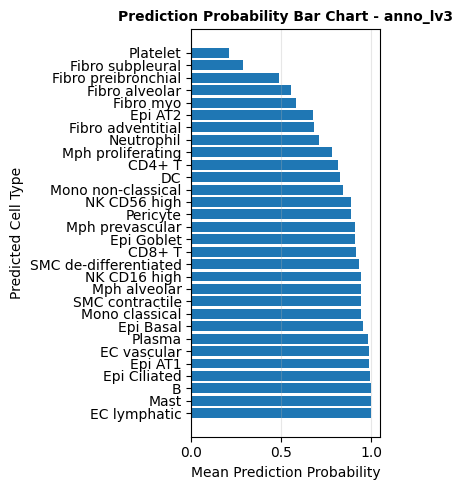

In [22]:
phmap.pl.plot_probability_bar(result, label_columns=['anno_lv3'], figsize=(4, 5), orientation='horizontal')

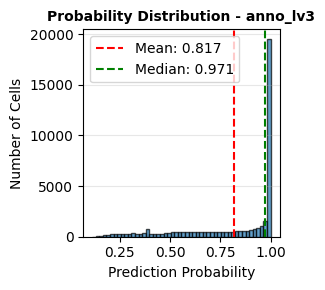

In [23]:
phmap.pl.plot_probability_distribution(result, label_columns=['anno_lv3'], figsize=(3, 3))

#### Perform prediction on each single sample (Recommand)

In [ ]:
qurey2 = qurey.copy()
qurey2.obs = qurey2.obs.drop(columns=['predicted_anno_lv1', 'predicted_anno_lv1_prob', 'predicted_anno_lv2', 'predicted_anno_lv2_prob', 'predicted_anno_lv3', 'predicted_anno_lv3_prob', 'predicted_anno_lv4', 'predicted_anno_lv4_prob'])
qurey2

AnnData object with n_obs × n_vars = 41119 × 22715
    obs: 'sample', 'dataset', 'group', 'batch', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'passing_mt', 'passing_nUMIs', 'passing_ngenes'
    var: 'ENSEMBL', 'SYMBOL', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
    uns: 'sample_colors'
    layers: 'counts'

In [18]:
query_list = [qurey2[qurey2.obs['sample'] == sample].copy() for sample in qurey2.obs['sample'].unique()]
[ad.shape for ad in query_list]

[(12218, 22715), (4406, 22715), (1254, 22715), (16467, 22715), (6774, 22715)]

In [19]:
%%time
result_list = []
for ad in query_list:
    result = phmap.predict(adata = ad, return_probabilities=True)
    ad = result.to_adata(ad)
    result_list.append(result)

INFO:phmap.core.classifier:Model loaded from /home/data/fhz/project/phmap_package/phmap/models/full_model/cell_type_classifier_full.pth
INFO:phmap.core.predictor:Model and metadata loaded from /home/data/fhz/project/phmap_package/phmap/models/full_model/cell_type_classifier_full.pth and /home/data/fhz/project/phmap_package/phmap/models/full_model/cell_type_classifier_full_metadata.pkl
INFO:phmap.core.predictor:Loaded default model 'full_model'
INFO:phmap.core.predictor:Prediction completed for 12218 cells
INFO:phmap.core.predictor:Prediction completed for 4406 cells
INFO:phmap.core.predictor:Prediction completed for 1254 cells
INFO:phmap.core.predictor:Prediction completed for 16467 cells
INFO:phmap.core.predictor:Prediction completed for 6774 cells


CPU times: user 23.2 s, sys: 7.97 s, total: 31.2 s
Wall time: 31.2 s


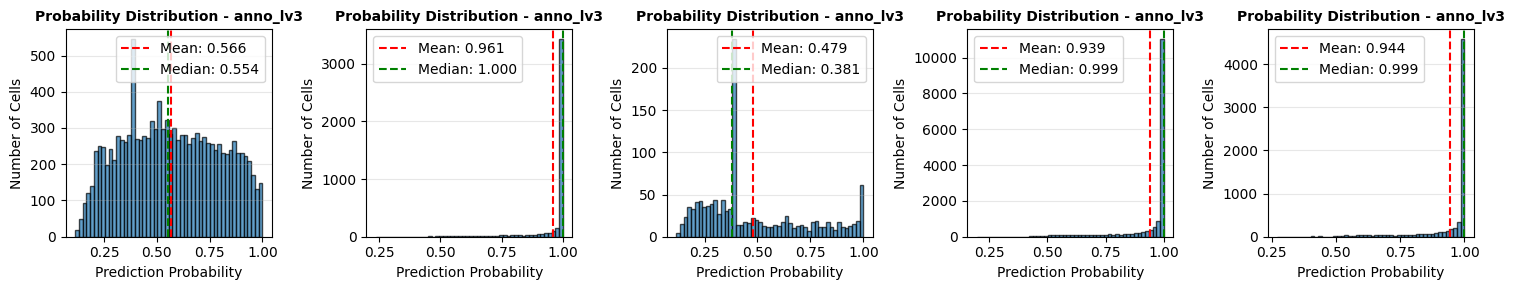

In [21]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, len(result_list), figsize=(3 * len(result_list), 3))
if len(result_list) == 1:
    axs = [axs]
for n, ax in enumerate(axs):
    phmap.pl.plot_probability_distribution(result_list[n], label_columns=['anno_lv3'], ax=ax)
plt.tight_layout()
plt.show()

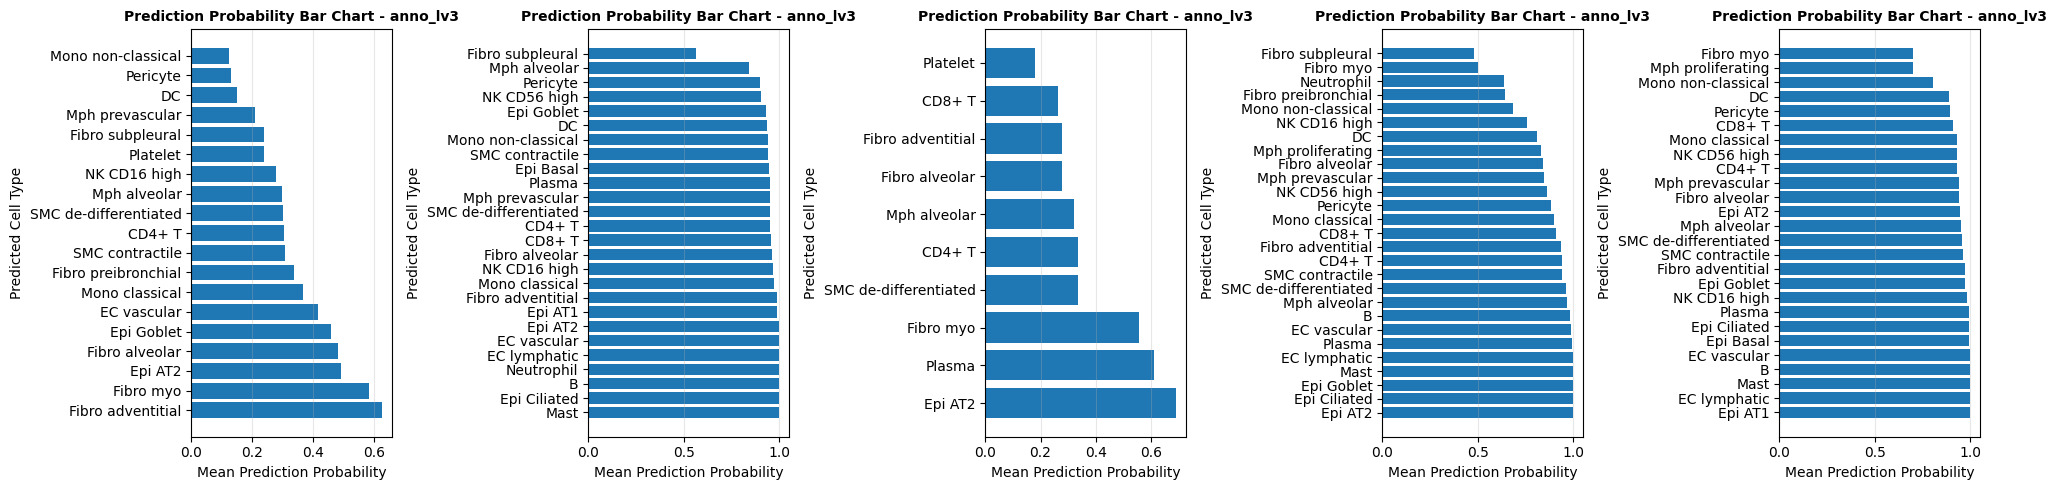

In [23]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, len(result_list), figsize=(4 * len(result_list), 5))
if len(result_list) == 1:
    axes = [axes]
for n, ax in enumerate(axes):
    phmap.pl.plot_probability_bar(result_list[n], label_columns=['anno_lv3'], orientation='horizontal', ax=ax)
plt.tight_layout()
plt.show()

In [20]:
# merged
query2 = query_list[0].concatenate(query_list[1:])
query2

AnnData object with n_obs × n_vars = 41119 × 22715
    obs: 'sample', 'dataset', 'group', 'batch', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'passing_mt', 'passing_nUMIs', 'passing_ngenes', 'predicted_anno_lv1', 'predicted_anno_lv1_prob', 'predicted_anno_lv2', 'predicted_anno_lv2_prob', 'predicted_anno_lv3', 'predicted_anno_lv3_prob', 'predicted_anno_lv4', 'predicted_anno_lv4_prob'
    var: 'ENSEMBL', 'SYMBOL', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
    layers: 'counts'

Then, you could use merged anndata for down-stream analysis.